# Focus: Concavity

In [1]:
import kagglehub
import pandas as pd # to work with dataframes, manipulate data (panel data)
import matplotlib.pyplot as plt # viz library
import seaborn as sns # HD viz library
import numpy as np # to work with numbers (numerical python)
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from scipy.stats import pearsonr

%matplotlib inline
pd.set_option('display.max_columns', None)

data = pd.read_csv(r'cleaned_data.csv')
df = data.copy()


c:\ProgramData\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Specifying only concavity related columns

In [2]:
df_concavity = df[['id', 'diagnosis','concavity_mean', 'concavity_se', 'concavity_worst' ]]

### Defining a new value column

Idea: Add a new value for the difference between mean concavity and concavity at worst to explore possible correlation focusing the change of size

In [3]:
# defining a new measure for the difference between the mean and the worst concavity
df_concavity = df_concavity.assign( concavity_diff = lambda x: (x['concavity_worst'] - x['concavity_mean'] ))
df_concavity

,id,diagnosis,concavity_mean,concavity_se,concavity_worst,concavity_diff
0,842302,M,0.30010,0.05373,0.7119,0.41180
1,842517,M,0.08690,0.01860,0.2416,0.15470
2,84300903,M,0.19740,0.03832,0.4504,0.25300
3,84348301,M,0.24140,0.05661,0.6869,0.44550
4,84358402,M,0.19800,0.05688,0.4000,0.20200
...,...,...,...,...,...,...
564,926424,M,0.24390,0.05198,0.4107,0.16680
565,926682,M,0.14400,0.03950,0.3215,0.17750
566,926954,M,0.09251,0.04730,0.3403,0.24779
567,927241,M,0.35140,0.07117,0.9387,0.58730


In [4]:
# filtering the DataFrame by diagnosis
df_M = df_concavity[df_concavity['diagnosis'] == 'M']
df_B = df_concavity[df_concavity['diagnosis'] == 'B']

### concavity histograms and overview

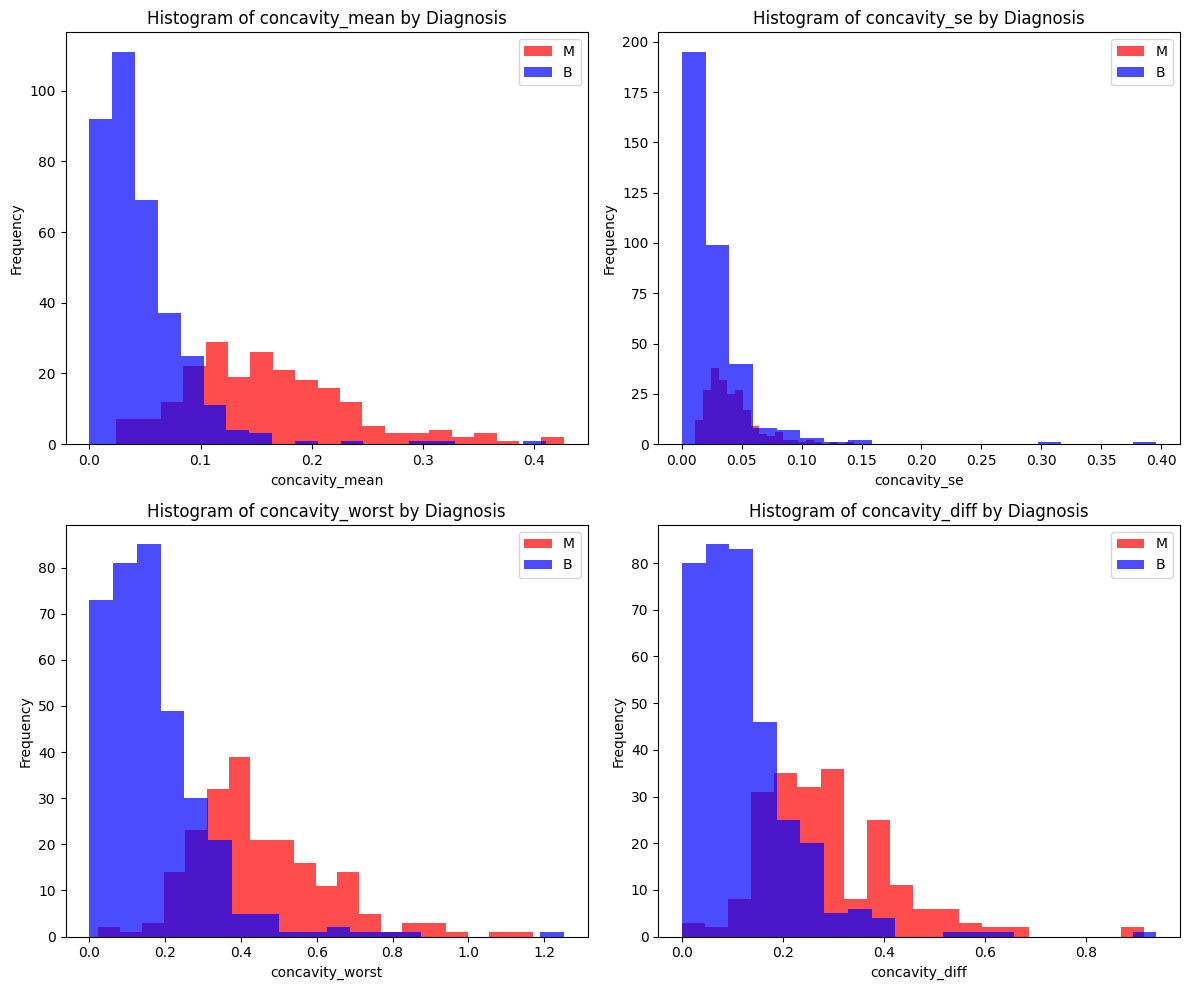

In [5]:
# list of concavity variables to compare
concavity_vars = ['concavity_mean', 'concavity_se', 'concavity_worst', 'concavity_diff']

# 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# loop through each concavity variable and plot overlapping histograms for "M" and "B"
for i, var in enumerate(concavity_vars):
    ax = axes[i // 2, i % 2]
    # filtering data by diagnosis
    data_M = df_concavity[df_concavity['diagnosis'] == 'M'][var]
    data_B = df_concavity[df_concavity['diagnosis'] == 'B'][var]
    
    # plot overlapping histograms with same style and colors:
    # diagnosis M in red and diagnosis B in blue, with alpha=0.7
    ax.hist(data_M, bins=20, alpha=0.7, label='M', color='red')
    ax.hist(data_B, bins=20, alpha=0.7, label='B', color='blue')
    
    ax.set_title(f"Histogram of {var} by Diagnosis")
    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.savefig('plots/histo_concavity.png')
plt.show()


### Closer look at the overlapping regions

C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_22456\3941741724.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df_overlap.groupby(var + '_bin')['diagnosis'].count()
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_22456\3941741724.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_cancer = df_overlap.groupby(var + '_bin')['diagnosis'].apply(lambda x: (x == 'M').sum() / len(x))
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_22456\3941741724.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain

concavity_mean_bin
(0.023, 0.0627]    0.078652
(0.0627, 0.101]    0.344444
(0.101, 0.14]      0.741935
(0.14, 0.179]      0.942308
(0.179, 0.217]     0.969697
(0.217, 0.256]     0.954545
(0.256, 0.295]     1.000000
(0.295, 0.333]     0.714286
(0.333, 0.372]     1.000000
(0.372, 0.411]     0.500000
Name: diagnosis, dtype: float64
concavity_se_bin
(0.009999999999999998, 0.0243]    0.213115
(0.0243, 0.0376]                  0.555556
(0.0376, 0.0508]                  0.619048
(0.0508, 0.0641]                  0.650000
(0.0641, 0.0774]                  0.642857
(0.0774, 0.0907]                  0.615385
(0.0907, 0.104]                   0.375000
(0.104, 0.117]                    0.750000
(0.117, 0.131]                    0.500000
(0.131, 0.144]                    0.500000
Name: diagnosis, dtype: float64
concavity_worst_bin
(0.023, 0.139]    0.021277
(0.139, 0.253]    0.128788
(0.253, 0.368]    0.528846
(0.368, 0.482]    0.869565
(0.482, 0.597]    0.925000
(0.597, 0.712]    0.892857
(0.712, 

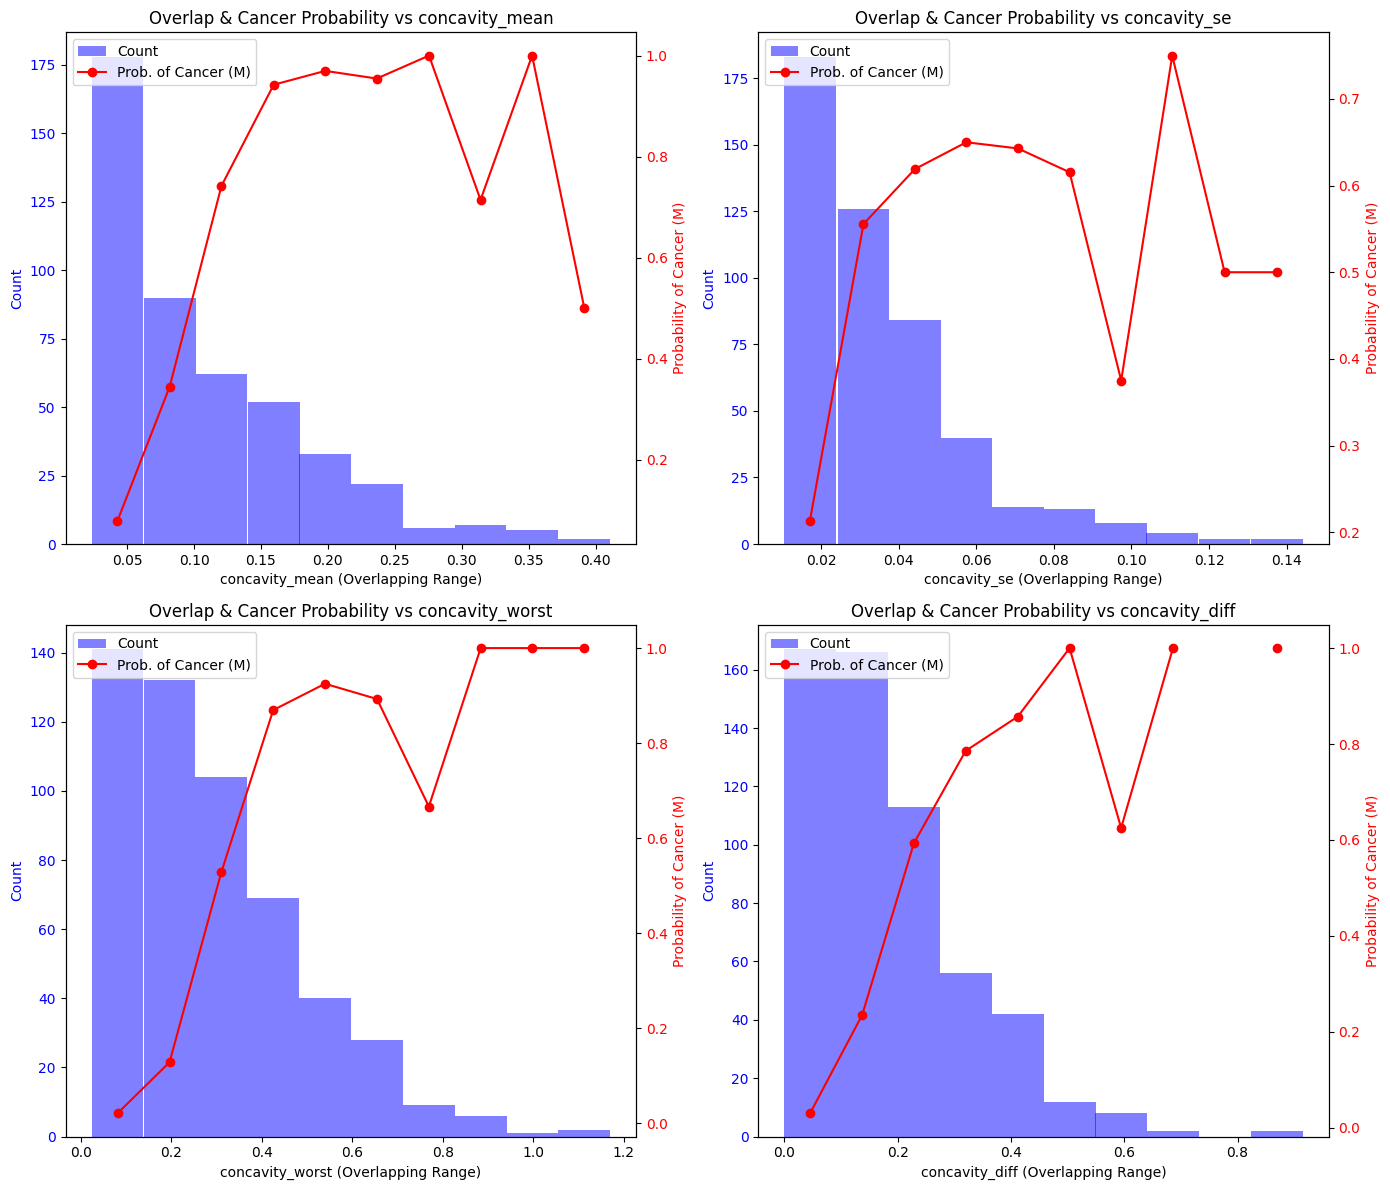

In [6]:
#  2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.flatten()

# loop over each concavity variable
for i, var in enumerate(concavity_vars):
    
    # determine the overlapping range for the variable
    min_overlap = max(df_M[var].min(), df_B[var].min())
    max_overlap = min(df_M[var].max(), df_B[var].max())
    
    # filter the DataFrame to the overlapping region
    df_overlap = df_concavity[(df_concavity[var] >= min_overlap) & (df_concavity[var] <= max_overlap)].copy()
    
    # create 10 evenly spaced bins in the overlapping range
    bins = np.linspace(min_overlap, max_overlap, 11)
    df_overlap[var + '_bin'] = pd.cut(df_overlap[var], bins=bins, include_lowest=True)
    
    # calculating counts for each bin and the probability of diagnosis "M"
    bin_counts = df_overlap.groupby(var + '_bin')['diagnosis'].count()
    prob_cancer = df_overlap.groupby(var + '_bin')['diagnosis'].apply(lambda x: (x == 'M').sum() / len(x))
    print(prob_cancer)

    # calculate bin centers and bin width
    bin_centers = [interval.mid for interval in bin_counts.index.categories]
    bin_width = bins[1] - bins[0]
    
    # plot on the current subplot
    ax = axes[i]
    # histogram (bar chart) for counts on primary y-axis (blue)
    ax.bar(bin_centers, bin_counts, width=bin_width, alpha=0.5, color='blue', label='Count')
    ax.set_xlabel(f"{var} (Overlapping Range)")
    ax.set_ylabel("Count", color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_title(f"Overlap & Cancer Probability vs {var}")
    
    # create a secondary y-axis for the probability curve (red)
    ax2 = ax.twinx()
    ax2.plot(bin_centers, prob_cancer.values, marker='o', linestyle='-', color='red', label='Prob. of Cancer (M)')
    ax2.set_ylabel("Probability of Cancer (M)", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('plots/histo_overlap_concavity.png')
plt.show()


### Boxplot overview of 4 concavity metrics

C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_22456\2687090427.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_concavity,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_22456\2687090427.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_concavity,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_22456\2687090427.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_concavity,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_22456\2687090427.py:8: FutureWarning:

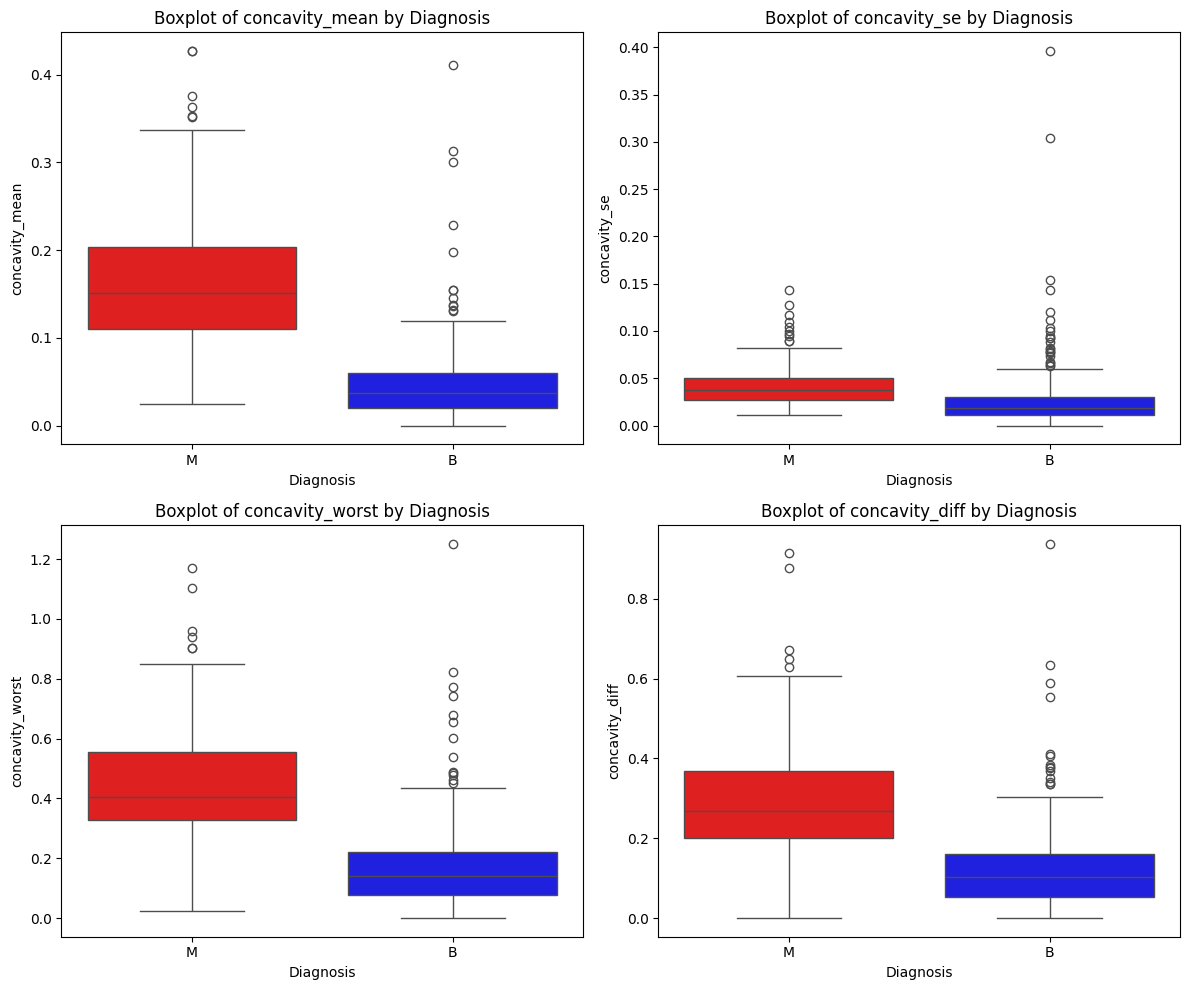

In [7]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # flatten the axes array so each element is an Axes instance

# Loop over each variable and generate a boxplot
for i, var in enumerate(concavity_vars):
    ax = axes[i]
    sns.boxplot(x='diagnosis', y=var, data=df_concavity,
                palette={'M': 'red', 'B': 'blue'}, ax=ax)
    ax.set_title(f"Boxplot of {var} by Diagnosis")
    ax.set_xlabel("Diagnosis")
    ax.set_ylabel(var)

plt.tight_layout()
plt.savefig('plots/boxplt_concavity.png')
plt.show()


### Pearson's correlation for concavity_mean, concavity_se, concavity_worst and concavitys_diff with diagnosis

In [8]:
df_concavity['diagnosis_numeric'] = df_concavity['diagnosis'].map({'B': 0, 'M': 1})

# list of concavity variables to analyze
concavity_columns = ['concavity_mean', 'concavity_se', 'concavity_worst', 'concavity_diff']

# dictionary for correlation results
results = {}

for col in concavity_columns:
    r, p = pearsonr(df_concavity['diagnosis_numeric'], df_concavity[col])
    results[col] = {'p-value': p, 'r-Pearson': r}

results_df = pd.DataFrame(results).T
print(results_df)


                      p-value  r-Pearson
concavity_mean   9.966556e-84    0.69636
concavity_se     8.260176e-10    0.25373
concavity_worst  2.464664e-72    0.65961
concavity_diff   3.956592e-51    0.57379


concavity mean and max(_worst) show the closest to 0 values, indicating strong correlation

### Chi-Square for the overlapping region for diagnosis and concavity mean

Let's pick the concavity metric with the smallest p-value and calculate its Chi-Square p-value.

Since the concavity is a continues numeric data, first converting it into discrete values within the overlapping region using binning technique and then calculating p-value of Chi-Square

In [9]:
# Determine overlapping range
min_overlap = max(df_M['concavity_mean'].min(), df_B['concavity_mean'].min())
max_overlap = min(df_M['concavity_mean'].max(), df_B['concavity_mean'].max())

df_overlap = df_concavity[(df_concavity['concavity_mean'] >= min_overlap) & (df_concavity['concavity_mean'] <= max_overlap)]

# create bins for the overlapping region (10 bins)
bins = np.linspace(min_overlap, max_overlap, 11)
df_overlap = df_overlap.copy()  # avoid SettingWithCopyWarning
df_overlap['concavity_bin'] = pd.cut(df_overlap['concavity_mean'], bins=bins, include_lowest=True)


contingency_table = pd.crosstab(df_overlap['concavity_bin'], df_overlap['diagnosis'])
print(contingency_table)


_,pvalue, _, _ = chi2_contingency(contingency_table)
cramer_v = association(contingency_table, method='cramer')
print(f'Chi-Square p-value is: {pvalue}\nCramer V is: {cramer_v}')


diagnosis          B   M
concavity_bin           
(0.023, 0.0627]  164  14
(0.0627, 0.101]   59  31
(0.101, 0.14]     16  46
(0.14, 0.179]      3  49
(0.179, 0.217]     1  32
(0.217, 0.256]     1  21
(0.256, 0.295]     0   6
(0.295, 0.333]     2   5
(0.333, 0.372]     0   5
(0.372, 0.411]     1   1
Chi-Square p-value is: 2.022185081770995e-48
Cramer V is: 0.7374721424144816


this extremely small p-value allows us to reject the null hypothesis of independence with high confidence. It shows that there is a statistically significant association between the concavity bins and the diagnosis (B vs. M). This means that the distribution of benign ("B") and malignant ("M") cases across the concavity intervals is not due to random chance, and the metric concavity appears to have a strong relationship with the diagnosis outcome.